# Análisis Exploratorio de los datos de Trocafone



### Propuestas


## Configuracion inicial

In [ ]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

In [ ]:
#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory=False)
df.head(5)

## Chequeos de integridad y calidad de los datos


In [ ]:
#Arreglo las fechas
df['timestamp']=pd.to_datetime(df['timestamp'])
df['timestamp'].head()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
#Categorizo ciertas columnas para ahorrar espacio en memoria
for columna  in ['event','condition','storage', 'color', 'staticpage', 'campaign_source', 'search_engine', 'channel', 'new_vs_returning', 'region', 'country', 'device_type']:
        df[columna] = df[columna].astype('category')
df.info()


## Analisis

In [ ]:
# Cantidad de eventos que no especifican valor para country
df['country'].isna().sum()

In [ ]:
df['country'].value_counts().head(10)

La mayor parte de los eventos que especifican country provienen de Brasil

In [ ]:
#Veo para que eventos se especifica el pais
eventos_con_country = df[df['country'].notna()]
eventos_con_country['event'].value_counts().head()

El unico evento que especifica valor para country es "visited site"


In [ ]:
eventos_brasil = df[df['country'] == 'Brazil']
eventos_brasil['person'].value_counts().head()

In [ ]:
df.loc[df['event'] == 'visited site'].describe()

Text(0.5,1,'Cantidad de eventos por dia de la semana')

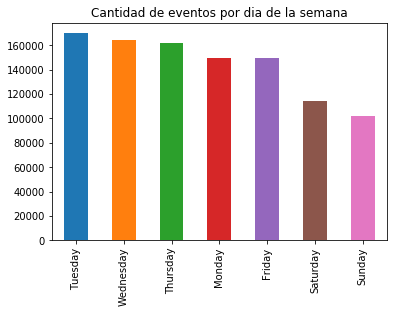

In [14]:
#Vamos a hacer un analisis sobre los dias en los que se produjeron los eventos
dias_semana = df['timestamp'].dt.weekday_name
g = dias_semana.value_counts().plot('bar')
g.set_title('Cantidad de eventos por dia de la semana')

## Analisis tipos de evento

In [ ]:
colUsadasEventos = df.groupby(by = 'event').count()
colUsadasEventos

In [ ]:
columns = list(df)
for event, row in colUsadasEventos.iterrows():
    print(event, end = ':')
    
    for column in columns:
        if(row.get(column) != 0):
            print(' ' + column, end = ',')
            
    print('\n')

## Columnas usadas por cada evento

Todos los eventos contienen informacion sobre **'timestamp'**, **'event'** y **'person'**, y ademas utilizan las siguientes columnas:

#### ad campaign hit:
    url, campaign_source
#### brand listing:
    skus
#### checkout: 
    sku, model, condition, storage, color

#### conversion: 
    sku, model, condition, storage, color

#### generic listing: 
    skus

#### lead: 
    model

#### search engine hit: 
    search_engine

#### searched products: 
    skus, search_term

#### staticpage: 
    staticpage

#### viewed product: 
    sku, model, condition, storage, color

#### visited site: 
    channel, new_vs_returning, city, region, country, device_type, screen_resolution, operating_system_version, browser_version


In [82]:
df_indice_en_persona_evento = df.set_index(['person','event'])
df_indice_en_persona_evento.head()

timestamp                        url  \
person   event                                                            
0004b0a2 ad campaign hit 2018-05-31 23:38:05  /comprar/iphone/iphone-5s   
         visited site    2018-05-31 23:38:05                        NaN   
         viewed product  2018-05-31 23:38:09                        NaN   
         checkout        2018-05-31 23:38:40                        NaN   
0006a21a viewed product  2018-05-29 13:29:25                        NaN   

                              sku              model condition storage  \
person   event                                                           
0004b0a2 ad campaign hit      NaN                NaN       NaN     NaN   
         visited site         NaN                NaN       NaN     NaN   
         viewed product    2694.0          iPhone 5s       Bom    32GB   
         checkout          2694.0          iPhone 5s       Bom    32GB   
0006a21a viewed product   15338.0  Samsung Galaxy S8       Bom    64GB   

                                   color skus search_term staticpage  \
person   event                                                         
0004b0a2 ad campaign hit             NaN  NaN         NaN        NaN   
         visited site                NaN  NaN         NaN        NaN   
         viewed product   Cinza espacial  NaN         NaN        NaN   
         checkout         Cinza espacial  NaN         NaN        NaN   
0006a21a viewed product          Dourado  NaN         NaN        NaN   

                            ...    new_vs_returning        city      region  \
person   event              ...                                               
0004b0a2 ad campaign hit    ...                 NaN         NaN         NaN   
         visited site       ...                 New  Camaragibe  Pernambuco   
         viewed product     ...                 NaN         NaN         NaN   
         checkout           ...                 NaN         NaN         NaN   
0006a21a viewed product     ...                 NaN         NaN         NaN   

                         country device_type screen_resolution  \
person   event                                                   
0004b0a2 ad campaign hit     NaN         NaN               NaN   
         visited site     Brazil  Smartphone           360x640   
         viewed product      NaN         NaN               NaN   
         checkout            NaN         NaN               NaN   
0006a21a viewed product      NaN         NaN               NaN   

                         operating_system_version   browser_version SeVendio  \
person   event                                                                 
0004b0a2 ad campaign hit                      NaN               NaN        0   
         visited site                   Android 6  Chrome Mobile 39        0   
         viewed product                       NaN               NaN        0   
         checkout                             NaN               NaN        0   
0006a21a viewed product                       NaN               NaN        0   

                               day  
person   event                      
0004b0a2 ad campaign hit  Thursday  
         visited site     Thursday  
         viewed product   Thursday  
         checkout         Thursday  
0006a21a viewed product    Tuesday  

[5 rows x 23 columns]

Timedelta('165 days 16:27:05')

In [90]:
def ver_diferencia_tiempo(tiempo):
    return tiempo.max()-tiempo.min()
    
diferencia_tiempo_entre_primero_y_ultimo_evento = df_indice_en_persona_evento.groupby('person').agg({'timestamp':ver_diferencia_tiempo})

In [100]:
diferencia_tiempo_entre_primero_y_ultimo_evento.loc[diferencia_tiempo_entre_primero_y_ultimo_evento['timestamp']>'1 day'].sort_values(by = 'timestamp')

,timestamp
person,
090de13e,1 days 00:02:28
c56e464b,1 days 00:02:34
482292d0,1 days 00:02:43
274c909c,1 days 00:03:07
20804569,1 days 00:03:11
883d144b,1 days 00:03:18
a7bc3bc9,1 days 00:03:21
cbd6d5ce,1 days 00:04:25
1e32b30a,1 days 00:05:04


# Quiero ver Que campaña publicitaria lleva a mas ventas

In [106]:
df.loc[]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [156]:
personas_por_publicidad = {}
    
ad_campaigns = df.loc[(df['event']=='ad campaign hit') | (df['event']=='conversion')].drop_duplicates()#[['person','campaign_source']].drop_duplicates().set_index('campaign_source')
ad_campaigns

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,SeVendio,day
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Thursday
6,2018-05-29 13:29:27,ad campaign hit,0006a21a,/comprar/samsung/galaxy-s8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Tuesday
11,2018-04-09 20:12:31,ad campaign hit,000a54b2,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Monday
15,2018-05-24 11:21:07,ad campaign hit,000a54b2,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Thursday
99,2018-05-17 00:08:56,ad campaign hit,0019c395,/comprar/samsung/galaxy-j5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Thursday
101,2018-05-17 00:11:10,ad campaign hit,0019c395,/comprar/samsung/galaxy-j5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Thursday
107,2018-06-08 12:15:33,ad campaign hit,001bb7eb,/comprar/iphone/6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Friday
111,2018-05-29 12:56:08,ad campaign hit,001f1653,/comprar/samsung/galaxy-s6-flat,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Tuesday
119,2018-01-31 16:54:29,ad campaign hit,00204059,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Wednesday
132,2018-02-01 23:32:02,ad campaign hit,00204059,/comprar/iphone,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Thursday


In [196]:
ad_campaigns_cool = df.loc[(df['event']=='ad campaign hit'),['person','campaign_source']].drop_duplicates()
ad_campaigns_cool.head()

,person,campaign_source
0,0004b0a2,criteo
6,0006a21a,criteo
11,000a54b2,google
99,0019c395,google
107,001bb7eb,google


In [215]:
personas_que_compraron = df.loc[df['event']=='conversion',['person']].drop_duplicates()
personas_que_compraron['compro'] = True
personas_que_compraron.head()

,person,compro
220,00204059,True
2282,00c13dee,True
2547,00fdbb4b,True
4245,0146a9df,True
6985,01db2fe6,True


In [216]:
compras_por_campania = pd.merge(ad_campaigns_cool, personas_que_compraron, on='person', how='left')
compras_por_campania.head(10)

,person,campaign_source,compro
0,0004b0a2,criteo,NaN
1,0006a21a,criteo,NaN
2,000a54b2,google,NaN
3,0019c395,google,NaN
4,001bb7eb,google,NaN
5,001f1653,criteo,NaN
6,00204059,FacebookAds,True
7,00204059,zanox,True
8,00204059,google,True
9,0024a82b,google,NaN


In [226]:
compras2 = compras_por_campania.groupby('campaign_source').agg({'person': 'count','compro':'count'})
compras2.head()

,person,compro
campaign_source,,
Facebook,44,5
FacebookAds,407,28
FacebookSocial,6,1
Google Social,1,0
MARKETING SOCIAL,1,0


Text(0.5,1,'Hits por campaña')

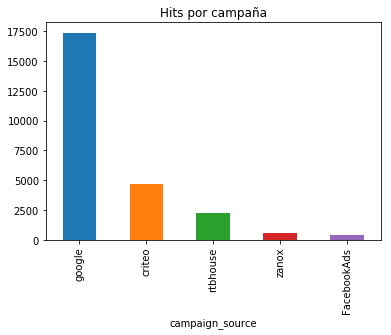

In [232]:
g = compras2['person'].sort_values(ascending=False).head().plot('bar')
g.set_title('Hits por campaña')